# Initial Analysis for Political Parties' Interests

## Mounting the Google Drive
The Quotebank data is stored on Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installs

In [ ]:
!python -m pip install --upgrade pip
!pip install pytrends
!pip install nltk
!pip install tld
!pip install pyarrow
!pip install qwikidata
!pip install sentence-transformers
!pip install transformers
!pip install umap-learn
!pip install hdbscan
!pip install tqdm

## Imports

In [3]:
import bz2
import json
import umap
import hdbscan
import nltk
import torch
import pyarrow
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as f
from tqdm import tqdm
from tld import get_tld
from itertools import chain
from datetime import datetime
from google.colab import drive
from collections import Counter
from nltk.corpus import stopwords
from pytrends.request import TrendReq
from nltk.cluster import KMeansClusterer
from sentence_transformers import SentenceTransformer
from transformers import BertModel, BertTokenizer
from sklearn.preprocessing import StandardScaler, normalize
from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api

## Constants

In [4]:
# Whether to create a parsed file from the Quotebank dataset.
PARSE_QUOTEBANK = True

# Colorblind-friendly color palette.
COLORS = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']

# A mapping between a year and the file that contains the input of that year.
QUOTES_BY_YEAR = {year: f"/content/drive/MyDrive/politicians-quotes-{year}.json.bz2" for year in range(2015, 2021)}

# A mapping between a party and quotes of its members
WIKIDATA_POLITICIANS_PATH = f"/content/drive/MyDrive/wikidata_politicians.csv"

# Path to parquet file used for Wikidata information
WIKIDATA_PATH = f"/content/drive/MyDrive/Quotebank_Wikidata/speaker_attributes.parquet"

# Path to file with mapping between q-codes and labels
WIKIDATA_LABELS_PATH = f"/content/drive/MyDrive/Quotebank_Wikidata/wikidata_labels_descriptions_quotebank.csv.bz2"

# Wikidata columns that are represented by q codes
WIKIDATA_QCODES_COL = ['occupation', 'party']

## Setup

In [5]:
# Connect to Google trends API
pytrend = TrendReq()
# NLTK setup
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Quote Parsing

The Quotebank data is too large to handle in-memory in a single DataFrame. Therefore, for our initial analyses we select only the quotes from 2018 that were uttered by politicians. We detect these quotes by looking at the Q IDs of the speakers, merging them with Wikidata based on the Q ID, resolving the Q IDs of their profession and filtering those quotes that belong to politicians.

In [6]:
# A list of politicians of interest.
politicians = ["Barack Obama", "George W. Bush", "Donald Trump", "John McCain",
            "Mitt Romney", "Hillary Clinton", "Benjamin Netanyahu",
            "Narendra Modi", "Joe Biden", "Theresa May", "Boris Johnson"]

In [7]:
def get_politicians_data(year):
  """
  Given a year, parses the Quotebank data and creates a file containing
  the quotes of politicians from that year.
  """
  path_to_out = QUOTES_BY_YEAR[year]
  path_to_file = f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'
  with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for i, instance in enumerate(s_file):
        # Load a sample.
        instance = json.loads(instance)
        if (sum([politician in instance['speaker'] for politician in politicians]) > 0):
          # Write sample to new file.
          d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
        print(i)

In [ ]:
get_politicians_data(2018)

In [ ]:
# Store politicians data in DataFrame.
data = pd.read_json(QUOTES_BY_YEAR[2018], lines=True)

Below, we look at a couple of quotes that belong to Donald Trump and Barack Obama, two of our politicians of interest.



In [ ]:
trump_quotes = data[data["speaker"].str.contains("Donald Trump")]
trump_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2018-05-08-001245,A constructive deal could easily have been str...,President Donald Trump,[Q22686],2018-05-08 18:36:49,8,"[[President Donald Trump, 0.5633], [None, 0.38...",[http://baynews9.com/fl/tampa/news/2018/05/08/...,E
1,2018-09-26-003692,actually admitted that they're going after far...,President Donald Trump,[Q22686],2018-09-26 00:00:00,138,"[[President Donald Trump, 0.6838], [None, 0.30...",[http://dailyherald.com/news/20180926/kavanaug...,E
3,2018-07-30-004176,always leaves room for negotiation.,President Donald Trump,[Q22686],2018-07-30 20:44:00,4,"[[President Donald Trump, 0.6616], [None, 0.33...",[http://www.10news.com/newsy/trump-25-billion-...,E
4,2018-10-30-005630,an incredible leader who is respected by every...,President Donald Trump,[Q22686],2018-10-30 03:10:00,3,"[[President Donald Trump, 0.358], [Cathy McMor...",[http://m.spokesman.com/stories/2018/oct/30/pr...,E
5,2018-04-21-003582,and he is already a proven liar and leaker.,President Donald Trump,[Q22686],2018-04-21 21:38:52,1,"[[President Donald Trump, 0.7394], [None, 0.16...",[https://mic.com/articles/189012/this-week-in-...,E


In [ ]:
obama_quotes = data[data["speaker"].str.contains("Barack Obama")]
obama_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
21,2018-02-12-035226,I cannot paint.,Barack Obama,[Q76],2018-02-12 13:50:00,2,"[[Barack Obama, 0.8319], [Kehinde Wiley, 0.090...",[http://www.chicagotribune.com/news/ct-obama-p...,E
35,2018-11-03-029313,"incessant, non-stop attempts to divide us with...",Barack Obama,[Q76],2018-11-03 01:43:21,3,"[[Barack Obama, 0.7987], [None, 0.164], [Donal...",[http://thehill.com/homenews/news/414678-obama...,E
106,2018-10-22-004462,All right? I believe in a fact-based reality. ...,President Barack Obama,[Q76],2018-10-22 21:36:28,1,"[[President Barack Obama, 0.7669], [None, 0.21...",[http://www.rawstory.com/2018/10/dont-believe-...,E
176,2018-10-26-096425,The biggest threat to our democracy is cynicis...,President Barack Obama,[Q76],2018-10-26 19:37:30,3,"[[President Barack Obama, 0.8994], [None, 0.08...",[http://cbsnews.com/news/live-stream-obama-ral...,E
201,2018-11-14-125138,was the day I was getting my hair and makeup d...,Barack Obama,[Q76],2018-11-14 16:01:00,1,"[[Barack Obama, 0.7869], [None, 0.2131]]",[http://www.wmagazine.com/story/michelle-obama...,E


## Quotes and Google Trends

One on of our theories is that politicians talk about subjects of interest. For example, when a major event takes place, we would expect to hear about it in the news, and more importantly, we would expect political stakeholders to talk about it. However, not all politicians may pay the same amount of attention to all events.

We plot the Google search trends against the number of quotes on specific subjects for Donald Trump and Barack Obama, two leaders from opposing parties.

In [ ]:
def plot_trend(all_quotes, keyword, year, ax, speaker_name):
  """
  Given a list of quotes, a keyword of interest and a year, plot the Google
  search trend against the politicians' trends of uttering related quotes.
  """
  # Get quotes stats from Quotebank
  relevant_quotes = all_quotes[all_quotes["quotation"].str.contains(keyword)]
  quotes_by_date = relevant_quotes.groupby(by=relevant_quotes['date'].dt.date)
  quotes_occ = pd.DataFrame(quotes_by_date['numOccurrences'].sum(),
                           columns=['numOccurrences'])

  # Get Google Trends data
  pytrend.build_payload(kw_list=[keyword], geo='US',
                        timeframe=f'{year}-01-01 {year}-12-31')
  df_google = pytrend.interest_over_time()

  # Treat missing quote trend values for a nicer plot
  idx = pd.date_range(f"01-01-{year}", f"12-31-{year}")
  quotes_occ = quotes_occ.reindex(idx, fill_value=0)

  # Scale trend
  quotes_occ["numOccurrences"] = StandardScaler().fit_transform(
    quotes_occ[["numOccurrences"]]
  )

  # Scale trend
  df_google[keyword] = StandardScaler().fit_transform(df_google[[keyword]])

  # Plot trends
  ax.plot(quotes_occ, label=f"{speaker_name} quote trend", color=COLORS[0])
  df_google.plot(y=keyword, use_index=True, ax=ax,
                 label='Google trend', color=COLORS[1])
  
  ax.set_title(f'Quotes & Search Trend for "{keyword}"')
  ax.set_xlabel('Date')
  ax.set_ylabel('Trend')
  ax.legend()

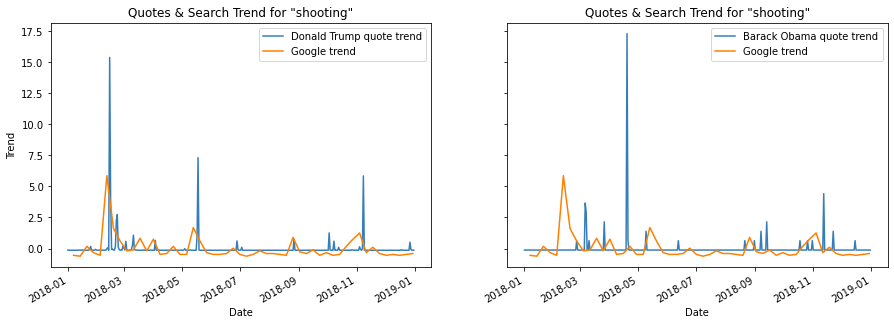

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=2, sharey=True)
plot_trend(trump_quotes, "shooting", 2018, axs[0], "Donald Trump")
plot_trend(obama_quotes, "shooting", 2018, axs[1], "Barack Obama")

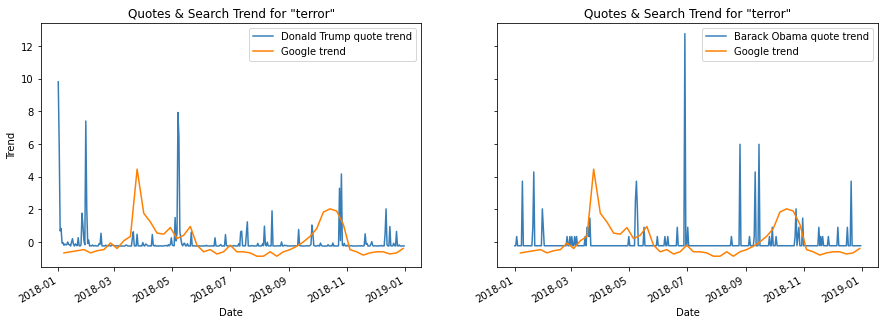

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=2, sharey=True)
plot_trend(trump_quotes, "terror", 2018, axs[0], "Donald Trump")
plot_trend(obama_quotes, "terror", 2018, axs[1], "Barack Obama")

## Most common words

We analyze the most common words said by Trump and Obama to see if we can find a pattern. For the current analysis, we only look at the most common nouns of each politician after tokenizing and preprocessing their quotes.

In [ ]:
def preprocess_text(text):
  """
  Apply NLTK preprocessing operations to extract more meaningful data
  from the quotes.
  """
  tokens = nltk.word_tokenize(text)
  # Remove stopwords
  stopwords_removed = [word for word in tokens if word not in stopwords.words("english")]
  tagged = nltk.pos_tag(stopwords_removed)
  # Return only nouns
  return [word for word, tag in tagged if tag.startswith('N') and word.isalpha()]

In [ ]:
# Count most common words for Donald Trump
trump_words_cnt = Counter(preprocess_text(" ".join(trump_quotes["quotation"].str.lower())))

In [ ]:
trump_words_cnt.most_common(30)

[('people', 14746),
 ('country', 8374),
 ('president', 6797),
 ('time', 5574),
 ('trump', 5079),
 ('states', 4818),
 ('lot', 4650),
 ('deal', 4224),
 ('world', 4175),
 ('things', 4015),
 ('years', 4005),
 ('trade', 3746),
 ('way', 3711),
 ('something', 3200),
 ('thing', 3179),
 ('countries', 2794),
 ('russia', 2741),
 ('democrats', 2729),
 ('security', 2508),
 ('nothing', 2311),
 ('china', 2304),
 ('border', 2256),
 ('job', 2242),
 ('news', 2217),
 ('money', 2042),
 ('year', 1971),
 ('today', 1946),
 ('house', 1867),
 ('america', 1826),
 ('day', 1824)]

In [ ]:
# Count most common words for Barack Obama.
obama_words_cnt = Counter(preprocess_text(" ".join(obama_quotes["quotation"].str.lower())))

In [ ]:
obama_words_cnt.most_common(30)

[('people', 1585),
 ('time', 654),
 ('president', 577),
 ('world', 574),
 ('way', 533),
 ('country', 533),
 ('politics', 488),
 ('years', 441),
 ('democracy', 419),
 ('things', 402),
 ('work', 359),
 ('power', 343),
 ('something', 325),
 ('life', 323),
 ('america', 320),
 ('obama', 272),
 ('day', 271),
 ('thing', 266),
 ('states', 263),
 ('change', 258),
 ('election', 255),
 ('house', 254),
 ('history', 254),
 ('kind', 247),
 ('vote', 243),
 ('today', 225),
 ('trump', 222),
 ('americans', 212),
 ('women', 211),
 ('man', 204)]

While Donald Trump talks about _Russia_, _China_, _money_, and _democrats_, Barack Obama chooses to talk about _democracy_, _change_, and _work_. This simple approach has revealed that although some of the main nouns are shared between the representants of the two parties, there are also differences that should be futher analyzed to figure out if they can tell us more about their parties.

In [ ]:
# Using this option to display the full quotes
pd.set_option('display.max_colwidth', None)

In [ ]:
obama_quotes[obama_quotes["quotation"].str.contains('gay')]['quotation'].head()

3028                                                                                                                                                                                             the scene of an uprising against police repression that led to a key turning point in the struggle for the civil rights of lesbian, gay, bisexual, and transgender (LGBT) Americans.
20109                                                                                                                                                                                        (W) hen I hear people say they don't like identity politics, I think it's important to remember that identity politics doesn't just apply when it's black people or gay people or women,
31804    I still have to stand here at a lecture and devote some time to saying that black people and white people and Asian people and Latin American people and women and men and gays and straights... are all human, that our differences are superficia

In [ ]:
trump_quotes[trump_quotes["quotation"].str.contains('gay')].head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
1861,2018-01-18-038590,I cannot vibe with gays,President Donald Trump,[Q22686],2018-01-18 17:42:12,1,"[[President Donald Trump, 0.5233], [None, 0.4767]]",[http://fuse.tv/2018/01/offset-migos-boss-life-queer-lyric-controversy-yfn-lucci],E
4127,2018-01-15-062263,"On the surface it may seem like Trump is giving a speech to one of our nation's most beloved icons -- the American farmer. But, the Farm Bureau actually represents a small, tight-knit clan of wealthy, far-right ideologues who oppose gay marriage and gun-free zones, support racist voter suppression laws, and want to gut social welfare programs like Medicaid.",President Donald Trump,[Q22686],2018-01-15 17:55:00,1,"[[President Donald Trump, 0.5711], [None, 0.4289]]",[http://www.southeastfarmpress.com/farm-policy/trump-afbf-what-did-everyone-else-say],E
15536,2018-10-29-025115,"has shown himself to be completely shameless when it comes to throwing anybody under the bus to score political points. As a gay man, I feel that threat.",President Donald Trump,[Q22686],2018-10-29 00:17:18,4,"[[President Donald Trump, 0.6485], [None, 0.2856], [Nickie Antonio, 0.0659]]","[https://www.ohio.com/news/20181028/blue-wave-lgbt-candidates-hope-for-rainbow-wave, https://www.times-gazette.com/news/20181031/blue-wave-lgbtq-candidates-hope-for-rainbow-wave, https://www.dispatch.com/news/20181101/blue-wave-lgbtq-candidates-hope-for-rainbow-wave, https://www.indeonline.com/news/20181101/blue-wave-lgbtq-candidates-hope-for-rainbow-wave]",E
24896,2018-02-13-074191,"It's not just for me. I got out there because -- it's not just gay kids, I think that everybody can relate to being different or feeling like they're not good enough or they'll never make it because they're from a small town, or maybe they just don't feel like they're good enough.",President Donald Trump,[Q22686],2018-02-13 16:14:48,2,"[[President Donald Trump, 0.3286], [None, 0.3038], [Mike Pence, 0.2501], [Adam Rippon, 0.1175]]","[http://people.com/sports/winter-olympics-2018-adam-rippon-message-haters/, http://people.com/sports/winter-olympics-2018-adam-rippon-gus-kenworthy-competing-openly-gay-athletes/]",E
30200,2018-01-26-124359,"Tomorrow marks the 73rd anniversary of the liberation of Auschwitz-Birkenau, the Nazi death and concentration camp in Poland. We take this opportunity to recall the Nazis' systematic persecution and brutal murder of six million Jewish people. In their death camps and under their inhuman rule, the Nazis also enslaved and killed millions of Slavs, Roma, gays, people with disabilities, priests and religious leaders, and others who courageously opposed their brutal regime,",President Donald Trump,[Q22686],2018-01-26 21:54:07,1,"[[President Donald Trump, 0.8092], [None, 0.1908]]",[http://israelnationalnews.com/News/News.aspx/241218],E


In [ ]:
# Resetting the column width
pd.reset_option('display.max_colwidth')

## News websites and speakers

### Helpers

In [ ]:
def get_domain_names(urls):
  """
  Get a list with all domain names for the urls list given as parameter.
  """
  domains = []
  for url in urls:
    res = get_tld(url, as_object=True)
    domains.append(res.domain)
  return domains

def standardize_speaker_name(x):
  """
  Standardize a speaker name to a common one from the list of politicians.
  """
  plts = np.array(politicians)
  return plts[[p in x for p in plts]][0]

### News websites' preference for a speaker

In [ ]:
# Do not alter original data
new_data_domains = data.copy()
# Convert urls into domain names -> this takes 1 minute
new_data_domains['urls'] = new_data_domains['urls'].apply(get_domain_names)

In [ ]:
# Standardize speaker names in order to be able to group quotes
new_data_domains['speaker'] = new_data_domains['speaker'].apply(standardize_speaker_name)
new_data_domains.head(10)
# Gather all sites that retreieved a politician's quotes
by_politician = new_data_domains.groupby('speaker')['urls'].agg(lambda x: list(chain.from_iterable(x.values))).reset_index()

In [ ]:
# Get number of quotes retrieved by a website, for each politician
politicians_websites = []
for index, row in by_politician.iterrows():
  p_websites = pd.DataFrame(Counter(row['urls']).most_common(5),
                                columns=["Website name", "{}".format(row['speaker'])])
  politicians_websites.append(p_websites)

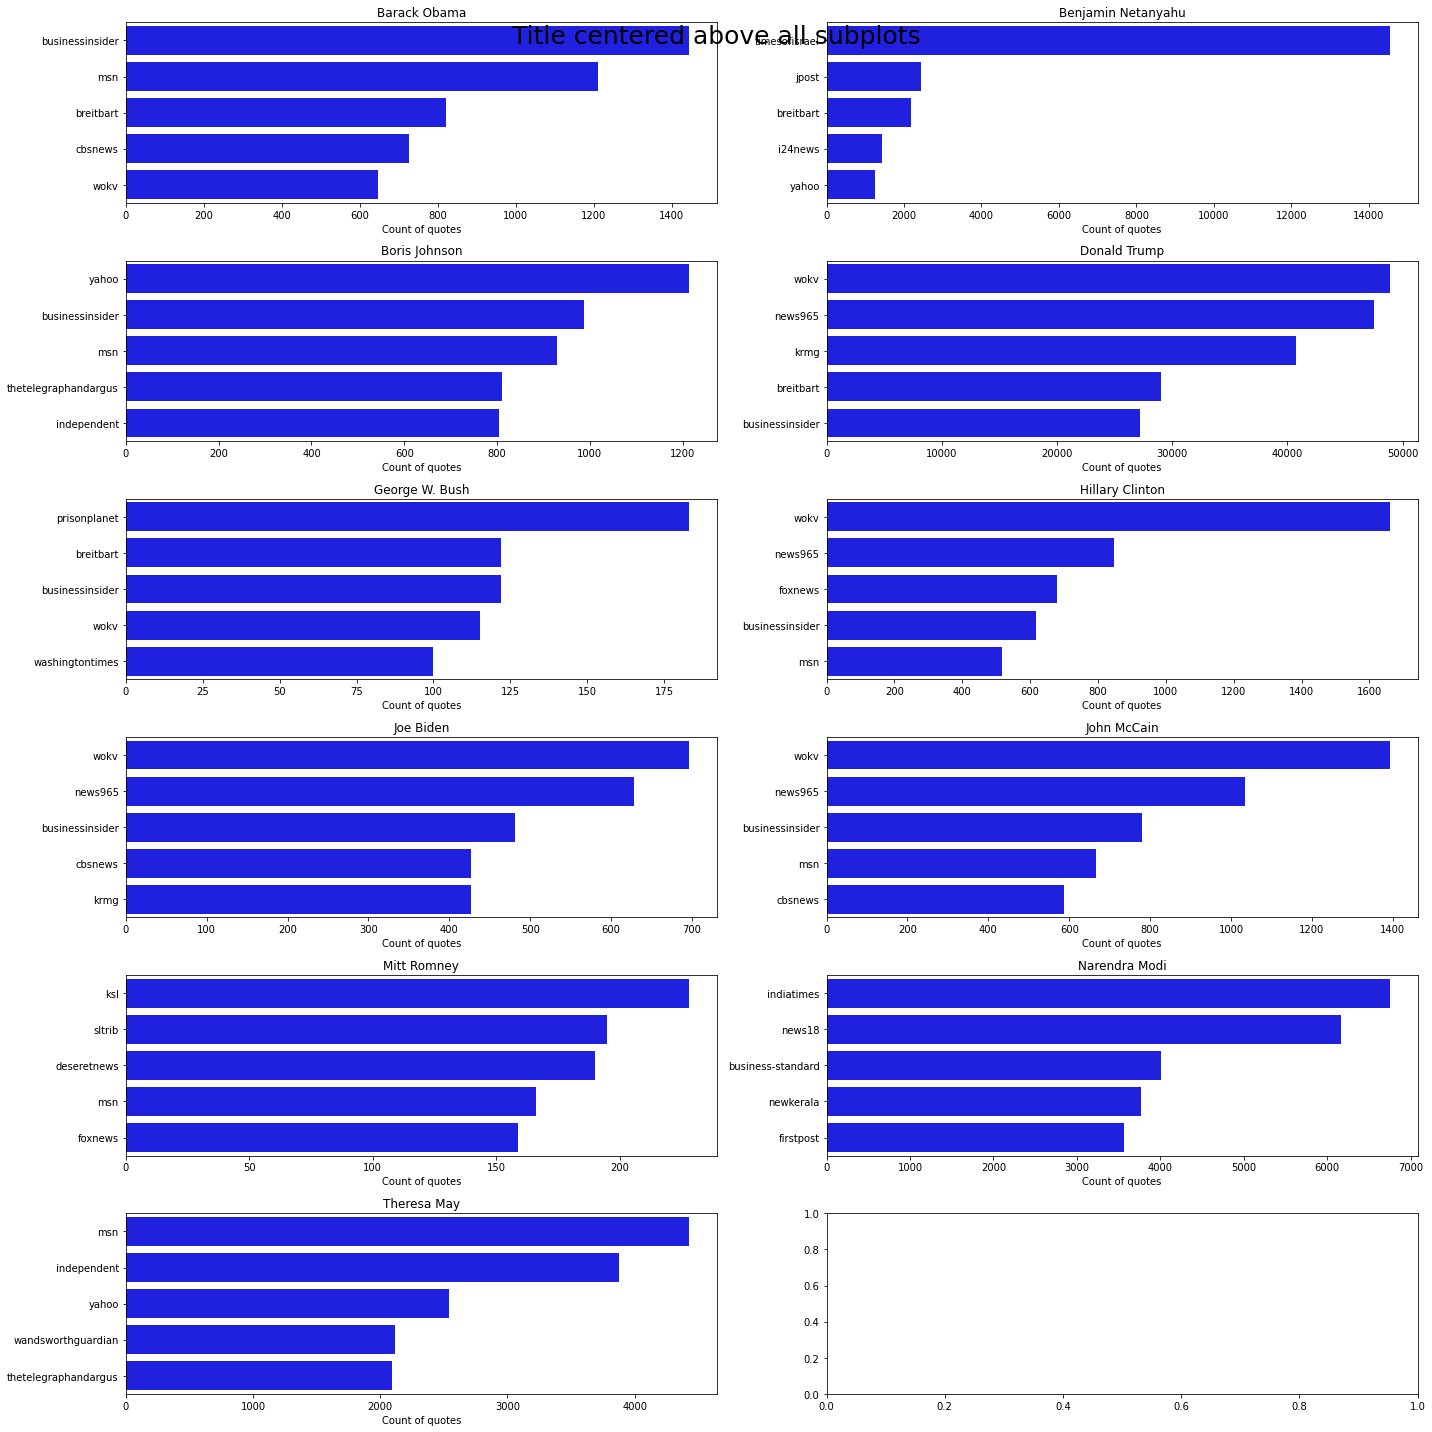

In [ ]:
# Plot the websites, preferences for each politician
w = 2
h = len(politicians_websites) // w + 1
fig, ax = plt.subplots(h, w, figsize=(20, 20))
# TODO: See why title is not showing
# fig.suptitle("Title centered above all subplots", fontsize=25)
for i in range(h):
  j = 0
  while i * w + j < len(politicians_websites) and j < w:
    sbplt = ax[i, j]
    ax_sns = sns.barplot(x=politicians_websites[j + i * w].columns[-1], y="Website name", 
                         data=politicians_websites[j + i * w], ax=sbplt, color='blue')#.set(xscale="log")
    ax_sns.set(xlabel="Count of quotes", ylabel=None, title=politicians_websites[j + i * w].columns[-1])
    j += 1
fig.tight_layout()

## Wikidata q-codes, first approach

### Helpers

In [ ]:
def convert_qcodes_en(q_codes):
  """
  Function for transforming wikidata q codes into list of english aliases or
  labels related to the specific q code. If list of q_codes is given aggregate
  all the words corresponding to each code. 
  """
  codes_values = []
  if q_codes is not None:
    for q_code in q_codes:
      s = get_entity_dict_from_api(q_code)
      s_value = []
      if len(s.get('aliases', {}).get("en", [])) > 0:
        s_value.extend([v["value"] for v in s['aliases']["en"]])
      if s.get('labels', {}).get("en", {}) != dict():
        s_value.append(s['labels']["en"]["value"])

      codes_values.extend(s_value)
  if len(codes_values) == 0:
    return None

  return codes_values

### Converting Q codes into list of aliases and label aggregated

In [ ]:
# Read .parquet file into a dataframe
wikidata = pd.read_parquet(WIKIDATA_PATH, engine='pyarrow')

In [ ]:
# Small test for converting wikidata qcodes into words (just first 5 entries)
new_wikidata = wikidata.iloc[:5].copy()
for name in WIKIDATA_QCODES_COL:
  new_wikidata[name] = new_wikidata[name].apply(convert_qcodes_en) 
new_wikidata.head(1)

## Select all politicians' quotes and merge them with wikidata 

### Helpers

In [8]:
def convert_qcodes(l, df):
  """
  Convert list of qcodes to labels
  """
  return None if l is None else list(map(lambda x: df.loc[x]['Label'] if x in df.index else None, l))


def infer_format(time_stmp):
    if time_stmp[6:8] == '00':
        time_stmp = time_stmp[:5]
        dt_format = '+%Y'
    else:
        time_stmp = time_stmp[:8]
        dt_format = '+%Y-%m'
    return time_stmp, dt_format

    
def get_party_membership(q_code):
    """
    Function for obtaining party membership intervals for speaker with q_code
    """
    tmp = []
    if q_code is not None:
        try:
            s = get_entity_dict_from_api(q_code)
        except:
            return None
        if len(s.get("claims", {}).get("P102", [])) > 0:
            for v in s["claims"]["P102"]:
                if v["mainsnak"].get("datavalue", {}).get("value", {}).get("id") is not None:
                    party = v["mainsnak"]["datavalue"]["value"]["id"]
                    if party in q_codes_labels.index:
                        party = q_codes_labels.loc[party]['Label']
                        # start_time, end_time = '+2008-07-31T00:00:00Z', '+2020-05-01T00:00:00Z'
                        start_time, end_time = None, None
                        if len(v.get('qualifiers', {}).get('P580', [])) > 0:
                            if v['qualifiers']['P580'][0].get('datavalue', {}).get("value", {}).get('time') is not None:
                                start_time = v['qualifiers']['P580'][0]["datavalue"]["value"]["time"]
                        if len(v.get('qualifiers', {}).get('P582', [])) > 0:
                            if v['qualifiers']['P582'][0].get('datavalue', {}).get("value", {}).get('time') is not None:
                                end_time = v['qualifiers']['P582'][0]["datavalue"]["value"]["time"]
                        if start_time is not None and end_time is not None:
                            tmp.append([party, datetime.strptime(*infer_format(start_time)),
                                        datetime.strptime(*infer_format(end_time))])
                        elif start_time is not None and end_time is None:
                            tmp.append([party, datetime.strptime(*infer_format(start_time)),
                                        datetime.strptime(*infer_format('+2020-05-01T00:00:00Z'))])
                        else:
                            continue

    if len(tmp) == 0:
        return None

    return tmp


def get_politicians_entire_data(year, wiki_politicians, proba_threshold=0.6, sub_samples=None):
    # Given a year, parses the Quotebank data and Wikidata and creates a file containing
    # the quotes of politicians from that year, with wikidata qcodes as labels.

    speaker_to_parties = {}
    path_to_out = QUOTES_BY_YEAR[year]
    path_to_file = f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'
    with bz2.open(path_to_file, 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for i, instance in tqdm(enumerate(s_file)):
                if sub_samples is not None and i > sub_samples:
                    break
                # Load a sample.
                instance = json.loads(instance)
                # Turn instance into Series
                instance = pd.Series(instance)
                # If there is un unknown speaker with the highest probability, 
                # therefore no qids or the attributed speaker has a lower
                # probability than a threshold, then pass
                if len(instance['qids']) == 0 or float(instance['probas'][0][1]) < proba_threshold:
                    continue
                # For each attributed qid in the list of qids
                for qid in instance['qids']:
                    # Get corresponding wiki_politicians sample for the specific qid in quotebank
                    # This happens only if quotebank speaker is politician in a party
                    try:
                        wikidata_sample = pd.DataFrame(wiki_politicians.loc[qid]).T
                    except KeyError:
                        continue
                    # Create new entry in series with politician qid
                    instance['qid_politician'] = qid
                    # Merge quotebank sample with wikidata sample based on qids
                    new_sample = pd.merge(pd.DataFrame(instance).T, wikidata_sample,
                                          left_on='qid_politician', right_index=True,
                                          how='inner')
                    # Transform dataframe into series
                    new_sample = new_sample.squeeze(axis=0)


                    # if qid not in speaker_to_parties:
                    #     # Create entry in dict of mappings between politicians and party memberships intervals
                    #     speaker_to_parties[qid] = get_party_membership(qid)
                    # # Map parties to parties membership intervals
                    # new_sample['party'] = speaker_to_parties[qid]
                    # # Get quote date
                    # quote_date = datetime.strptime(new_sample['quoteID'][:7], '%Y-%m')
                    # # Select the party membership interval corresponding to the quote date
                    # if new_sample['party'] is not None:
                    #     new_sample['party'] = [p for p in new_sample['party'] if p[1] <= quote_date < p[2]]
                    #     # If no membership interval found, take the last party
                    #     if len(new_sample['party']) == 0:
                    #         continue
                    #         # new_sample['party'] = [speaker_to_parties[qid][-1]]
                    #     # If multiple parties found  take the last one
                    #     if len(new_sample['party']) > 1:
                    #         new_sample['party'] = [speaker_to_parties[qid][-1]]


                    # Write to file
                    d_file.write((new_sample.to_json() + '\n').encode('utf-8'))

### Get wikidata politicians (DO NOT RUN THIS AGAIN, FILE ALREADY CREATED)

In [ ]:
# Mapping between wikidata q codes and their labels
q_codes_labels = pd.read_csv(WIKIDATA_LABELS_PATH, compression='bz2', index_col='QID')

In [ ]:
q_codes_labels.head(3)

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks


In [ ]:
# Read wikidata .parquet file into a dataframe
wikidata = pd.read_parquet(WIKIDATA_PATH, engine='pyarrow').set_index('id')
party_qcodes = wikidata['party']
# Map qcodes to labels
wikidata = wikidata[WIKIDATA_QCODES_COL].progress_applymap(lambda lst: convert_qcodes(lst, q_codes_labels))
wikidata['party_qcodes'] = party_qcodes.values
wikidata.head(3)

100%|██████████| 18111962/18111962 [24:31<00:00, 12307.74it/s] 


,occupation,party
id,,
Q23,"[politician, military officer, farmer, cartogr...",[independent politician]
Q42,"[playwright, screenwriter, novelist, children'...",None
Q1868,"[writer, lawyer, librarian, information scient...",None


In [ ]:
# Total entries in wikidata
wikidata.shape

(9055981, 3)

In [ ]:
# Keep only politicians
wikidata_politicians = wikidata.loc[wikidata['occupation'].apply(lambda lst: 'politician' in str(lst))]
wikidata_politicians.head(3)

,occupation,party,party_qcodes
id,,,
Q23,"[politician, military officer, farmer, cartogr...",[independent politician],[Q327591]
Q207,"[politician, motivational speaker, autobiograp...",[Republican Party],[Q29468]
Q368,"[military officer, politician]",[independent politician],[Q327591]


In [ ]:
# Total number of politicians
wikidata_politicians.shape

(659455, 3)

In [ ]:
# Save table with wikidata politicians
wikidata_politicians.to_csv('/content/drive/MyDrive/wikidata_politicians.csv')

### Code

In [9]:
# Read dataframe with wikidata politicians
wikidata_politicians = pd.read_csv(WIKIDATA_POLITICIANS_PATH).set_index('id')
# Keep only the ones belonging to a party
wikidata_politicians_in_party = wikidata_politicians.loc[~wikidata_politicians['party'].isna()]
print("There are {} politicians belonging to at least a party in Wikidata !".format(wikidata_politicians_in_party.shape[0]))

There are 305302 politicians belonging to at least a party in Wikidata !


In [ ]:
# Create zipped file for a specific year, with all Quotebank's entries where
# the speaker is a politician belonging to a party
for i in range(2015, 2021):
    get_politicians_entire_data(i, wikidata_politicians_in_party)
    print("Year {} ended !\n".format(i))

855431it [17:05, 875.09it/s]

In [12]:
# Read the data just created
data = pd.read_json(QUOTES_BY_YEAR[2018], lines=True)

In [ ]:
data.head(2)

In [ ]:
# Number of parties and number of speakers belonging to each party
parties_occ = dict(Counter(data['party'].agg(lambda x: x[0][0] if x is not None else 'no_party')))
sorted_parties = sorted(parties_occ.items(), key=lambda x: x[1], reverse=True)
print("Number of parties is: {}\n".format(len(sorted_parties)))
sorted_parties = dict(sorted_parties)
sorted_parties

Number of parties is: 35



{'Australian Labor Party': 1,
 'Bangladesh Nationalist Party': 1,
 'Bharatiya Janata Party': 2,
 'Christian Democratic Union': 3,
 'Civic Choice': 1,
 'Coalition Avenir Québec': 1,
 'Comités Jeanne': 1,
 'Communist Party of China': 2,
 'Conservative Party': 2,
 'Democratic Party': 3,
 'Democratic Party of Korea': 1,
 'Democratic Unionist Party': 1,
 'Economic Freedom Fighters': 1,
 'Free Democratic Party': 1,
 'Green Party of England and Wales': 1,
 'Indian National Congress': 1,
 'Initiative for Catalonia Greens': 1,
 'Justice and Development Party': 4,
 'La République En Marche': 6,
 'Lega Nord': 3,
 'Liberal Democratic Party': 1,
 'Likud': 4,
 'Malaysian United Indigenous Party': 6,
 'National Party of Australia': 1,
 'National Rally': 1,
 'Republican Party': 48,
 'Russia of the Future': 1,
 'Sabah Heritage Party': 1,
 'Scottish Conservatives': 1,
 'Senate Liberal Caucus': 1,
 'Socialist Alternative': 1,
 'Socialist Party': 1,
 'United Socialist Party of Venezuela': 1,
 'Yisrael Bei

## BERT

In [ ]:
# Check cuda runtime and set model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer('bert-base-nli-mean-tokens')
print(device)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

cuda


In [ ]:
# Find sentence embeddings
sentence_embeddings = model.encode(list(data['quotation']), show_progress_bar=True)
# Reduce dimensionality of embeddings
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(sentence_embeddings)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Cluster documents
cluster = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

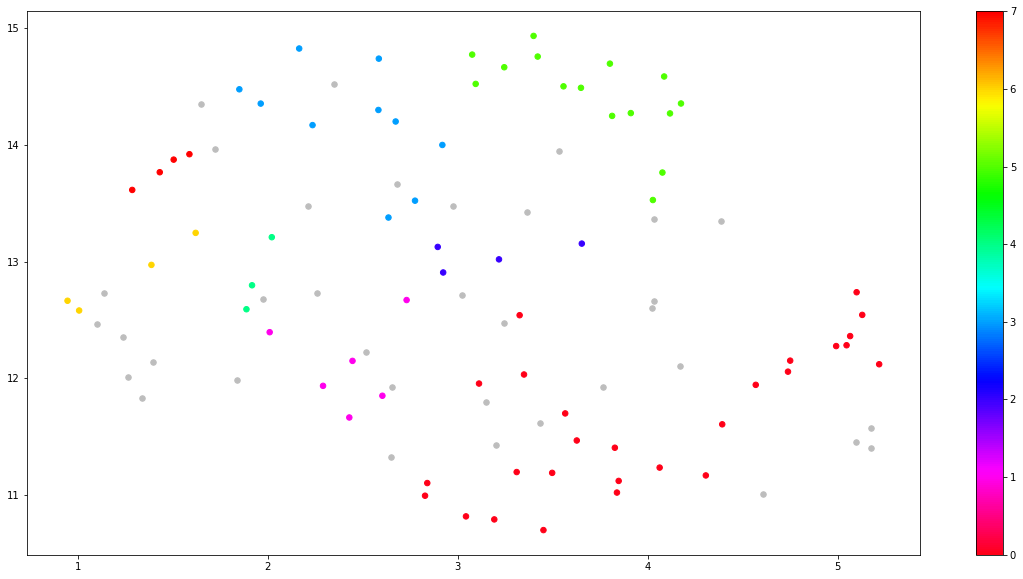

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(sentence_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_
data['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=30)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=30, cmap='hsv_r')
plt.colorbar()

In [ ]:
# Check a cluster results
clusters = data.groupby('labels')[['quotation', 'party']].agg(list)
clusters.quotation.loc[5]

['and he is already a proven liar and leaker.',
 'could be one of the single most unfair, unjust things to happen for a candidate for anything.',
 'each one of them have their own personality whether it be a clown, or a couch potato, whether they just bounce off the walls.',
 'has directly or indirectly produced tremendous legal and political peril for Trump,',
 "If we don't get tough on the drug dealers, we're wasting or time. And that toughness includes the death penalty.",
 'Islamophobic, Turcophobic, xenophobic and racist.',
 "John Brennan is panicking. He has disgraced himself, he has disgraced the Country, he has disgraced the entire Intelligence Community. He is the one man who is largely responsible for the destruction of American's faith in the Intelligence Community and in some people at the....",
 'Many aliens who illegally enter the United States and those who overstay... the terms of their visas present a significant threat to national security and public safety.',
 'murde

In [ ]:
# Get the parties interested in topic 3 
Counter((map(lambda x: x[0][0], clusters.party.loc[5])))

Counter({'Conservative Party': 1,
         'Free Democratic Party': 1,
         'Indian National Congress': 1,
         'Justice and Development Party': 1,
         'La République En Marche': 2,
         'Lega Nord': 1,
         'National Rally': 1,
         'Republican Party': 7})

In [ ]:
# Get another cluster's quotes
clusters.quotation.loc[0]

['After another day of voting in the Knesset, I would like to thank Dudi Amsalem, who is doing an excellent job as chairman of the coalition.',
 'After they claimed the prime minister smoked one million shekels worth of cigars, here comes more hot air: Benefits worth a billion shekel,',
 'bold and responsible plan. We believe it is the most well-researched, thoughtful state tax reform effort in America.',
 'borrowing from the successful approach in Germany and other developed economies',
 "China's per capita income is moving up from the current level of 8,000-plus to 10,000 U.S. dollars and even higher. At such a stage of development, China needs to put more emphasis on structural improvement rather than quantity expansion,",
 'DOE works closely with leaders in manufacturing to develop next generation technologies that will boost American job growth and strengthen domestic industries.',
 "Everything's renting overall, but they're finding those areas more popular because they have the f

In [ ]:
# Get the parties interested in topic 1
Counter((map(lambda x: x[0][0], clusters.party.loc[0])))

Counter({'Christian Democratic Union': 1,
         'Communist Party of China': 1,
         'Conservative Party': 1,
         'Democratic Party': 2,
         'Initiative for Catalonia Greens': 1,
         'La République En Marche': 1,
         'Lega Nord': 2,
         'Likud': 2,
         'Malaysian United Indigenous Party': 1,
         'Republican Party': 10,
         'Sabah Heritage Party': 1,
         'Senate Liberal Caucus': 1,
         'Socialist Alternative': 1,
         'Socialist Party': 1,
         'independent politician': 1})

**or another approach**


In [ ]:
def clustering_question(data,NUM_CLUSTERS = 3):

    sentences = data['quotation']

    X = np.array(data['embeddings'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])

    return data, assigned_clusters

In [ ]:
data['embeddings'] = sentence_embeddings.tolist()
data, clusters = clustering_question(data)
data.head(3)

## Suggestions

*   Apply "get_membership_party" on yearly resulted dataframes

*   Tune parameters for UMAP
*   Tune parameters for HDBSCAN




